# Inverted Pendulum PID Controller

Demonstration of controlling an inverted pendulum using a PID controller.

**Author:** Shawn Hymel<br>
**Date:** 2023-08-05

Run stm32-stepper-encoder-control.ino on your STM32 Nucleo board. Connect the USB, change the serial port designator, and run through the cells to test controlling the pendulum.

Intended for the following inverted pendulum kit: [STEVAL-EDUKIT01](https://www.st.com/en/evaluation-tools/steval-edukit01.html)

Install the following packages:

```
python -m pip install pyserial
```

**License:** Zero-Clause BSD

Permission to use, copy, modify, and/or distribute this software for
any purpose with or without fee is hereby granted.

THE SOFTWARE IS PROVIDED “AS IS” AND THE AUTHOR DISCLAIMS ALL
WARRANTIES WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES
OF MERCHANTABILITY AND FITNESS. IN NO EVENT SHALL THE AUTHOR BE LIABLE
FOR ANY SPECIAL, DIRECT, INDIRECT, OR CONSEQUENTIAL DAMAGES OR ANY
DAMAGES WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN
AN ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT
OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.

In [1]:
from control_comms import ControlComms, StatusCode, DebugLevel
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

In [2]:
# Constants
SERIAL_PORT = "COM10"    # Check your devices
BAUD_RATE = 500000      # Must match what's in the Arduino code!
TIMEOUT = 1.0           # Seconds
DEBUG_LEVEL = DebugLevel.DEBUG_ERROR

In [3]:
# Communication constants
CMD_SET_HOME = 0        # Set current stepper position as home (0 deg)
CMD_MOVE_TO = 1         # Move stepper to a particular position (deg)
CMD_MOVE_BY = 2         # Move stepper by a given amount (deg)
CMD_SET_STEP_MODE = 3   # Set step mode
CMD_SET_BLOCK_MODE = 4  # Set blocking mode
STEP_MODE_1 = 0         # 1 division per step
STEP_MODE_2 = 1         # 2 divisions per step
STEP_MODE_4 = 2         # 4 divisions per step
STEP_MODE_8 = 3         # 8 divisions per step
STEP_MODE_16 = 4        # 16 divisions per step
STATUS_OK = 0           # Stepper idle
STATUS_STP_MOVING = 1   # Stepper is currently moving

In [4]:
# Close connection to Arduino board (if open)
try:
    ctrl.close()
except:
    pass

In [5]:
# Connect to Arduino board
ctrl = ControlComms(timeout=TIMEOUT, debug_level=DEBUG_LEVEL)
ret = ctrl.connect(SERIAL_PORT, BAUD_RATE)
if ret is not StatusCode.OK:
    print("ERROR: Could not connect to board")

In [28]:
# Test control
resp = ctrl.step(CMD_SET_STEP_MODE, [STEP_MODE_8])
# resp = ctrl.step(CMD_SET_BLOCK_MODE, [1])
resp = ctrl.step(CMD_SET_HOME, [0])
resp = ctrl.step(CMD_MOVE_BY, [-90.0])
if resp:
    status, timestamp, terminated, obs = resp
    print(f"Status: {status}")
    print(f"Timestamp: {timestamp}")
    print(f"Terminated: {terminated}")
    print(f"Observation: {obs}")
else:
    print("ERROR: Could not communicate with Arduino")

Status: 1
Timestamp: 826474
Terminated: False
Observation: [182.4, 0.0]


Episode terminated
Average interval: 4.113636363636363 ms


Text(0.5, 0, 'Step')

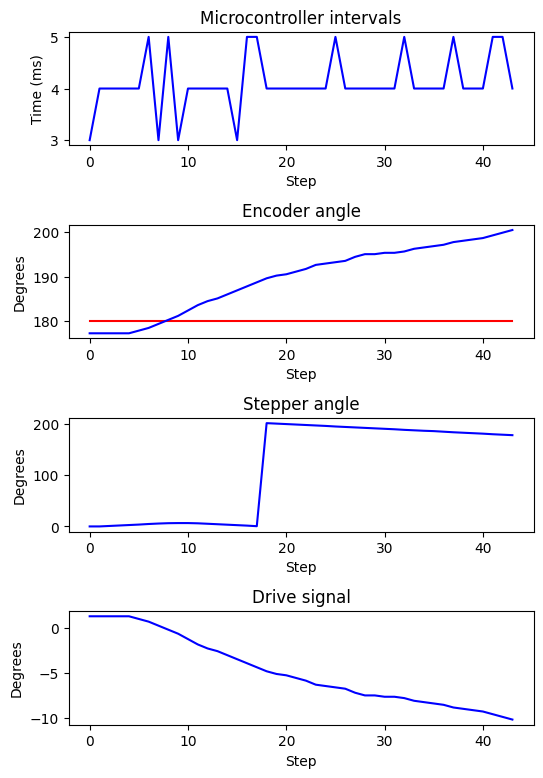

In [35]:
# PID controller constants for tuning
K_P = 0.5
K_I = 0.0
K_D = 0.0
BIAS = 0

# Other controller constants
SETPOINT = 180
NUM_STEPS = 1000000
ENC_GUARD_DEGS = [160, 200]
STEP_MODE = STEP_MODE_8

# Metrics to store
intervals = []
enc_degs = []
stp_degs = []
move_degs = []

# Set step mode, set current position to home, and get timestamp
resp = ctrl.step(CMD_SET_STEP_MODE, [STEP_MODE])
resp = ctrl.step(CMD_SET_HOME, [0])
if resp:
    _, timestamp_prev, _, _ = resp
else:
    print("ERROR: Could not communicate with Arduino")
    timestamp_prev = 0

# Try to keep pendulum in upright position
error_prev = 0
integral = 0
move_deg = 0
for i in range(NUM_STEPS):
    
    # Take a step and get observation
    resp = ctrl.step(CMD_MOVE_BY, [move_deg])
    if resp:
        status, timestamp, terminated, obs = resp
    else:
        print("ERROR: Could not communicate with Arduino")
        continue
    
    # Get observation values
    enc_deg = obs[0]
    stp_deg = obs[1]
    
    # Calculate time between this step and the previous
    interval = timestamp - timestamp_prev
    timestamp_prev = timestamp
    
    # Calculate the PID terms
    error = SETPOINT - enc_deg
    integral = integral + (error * interval)
    derivative = (error - error_prev) / interval
    move_deg = (K_P * error) + (K_I * integral) + (K_D * derivative) + BIAS
    
    # Save error value for next iteration
    error_prev = error
    
    # Store metrics
    intervals.append(interval)
    move_degs.append(move_deg)
    enc_degs.append(enc_deg)
    stp_degs.append(stp_deg)
    
    # Stop if encoder goes past one of our guard angles
    if enc_deg < ENC_GUARD_DEGS[0] or enc_deg > ENC_GUARD_DEGS[1]:
        print("Episode terminated")
        break
    
# Calculate average interval
print(f"Average interval: {sum(intervals) / len(intervals)} ms")
    
# Create plots
fig, ax = plt.subplots(4, 1, figsize=(6, 9))
plt.subplots_adjust(hspace=0.7)

# Plot intervals measured from microcontroller
ax[0].plot(intervals, color='blue')
ax[0].set_title("Microcontroller intervals")
ax[0].set_ylabel("Time (ms)")
ax[0].set_xlabel("Step")

# Plot setpoint and encoder degrees
ax[1].plot([SETPOINT] * len(enc_degs), color='red')
ax[1].plot(enc_degs, color='blue')
ax[1].set_title("Encoder angle")
ax[1].set_ylabel("Degrees")
ax[1].set_xlabel("Step")

# Plot stepper degrees
ax[2].plot(stp_degs, color='blue')
ax[2].set_title("Stepper angle")
ax[2].set_ylabel("Degrees")
ax[2].set_xlabel("Step")

# Plot output signals
ax[3].plot(move_degs, color='blue')
ax[3].set_title("Drive signal")
ax[3].set_ylabel("Degrees")
ax[3].set_xlabel("Step")